# Homework 1

1. Fork the class repository, clone, and create a directory `hw1` inside the repository.  Add your source file(s) to that directory.
2. Write a function `diffmat(x)` that returns a square matrix $D$ that computes first derivatives at all points.
3. Write a function `diff2mat(x)` that returns a square matrix $D_2$ that computes second derivatives at all points.
4. Use test solutions to determine the order of accuracy of your methods for evenly and non-evenly spaced points.  Which norm did you use?
5. Add `README.md` in the `hw1` directory and summarize your results (one paragraph or a few bullet items is fine).
6. Commit (`git commit`) your source code and `README.md` in the `hw1` directory and push to your fork.  I'll pull from there after the due date.


* You may assume that the points `x` are monotonically increasing.
* You'll need to think about what to do at the endpoints.

## Jed's suggestions

We would like a second order accurate discretization of the derivative $u'(0)$ using $u(0), u(x), and u(y)$.  We could use a Taylor expansion
\begin{gather}
u(x) = u(0) + u'(0) x + u''(0) x^2/2 + O(x^3) \\
u(y) = u(0) + u'(0) y + u''(0) y^2/2 + O(y^3)
\end{gather}
and ask for coefficients $\{ s_0, s_1, s_2 \}$ such that
$$ s_0 u(0) + s_1 u(x) + s_2 u_(y) = u'(0) + O(x^3) + O(y^3) . $$
This turns out to be equivalent to polynomial interpolation followed by differentiation.  It is implemented in the `fdstencil` function in `fdtools.py`.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

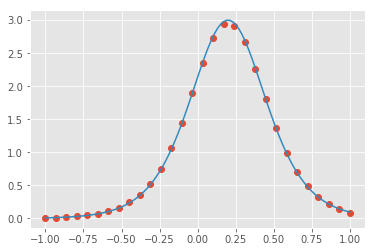

In [2]:
# We have utility functions like cosspace and chebeval defined
# in the file fdtools.py.  We would like to import it here, but
# perhaps we would like to be able to edit the file and yet keep
# using it from inside the notebook.  If we just import fdtools,
# then the file won't be reloaded unless we restarted the Jupyter
# kernel.  The %run command is much like
#
#     from fdtools import *
#
# but actually re-runs the file each time.
%run fdtools.py

def diffmat(x):
    m = len(x)
    D = numpy.zeros((m, m))
    D[0,:3] = fdstencil(x[0], x[:3])[1]
    for i in range(1, m-1):
        D[i, i-1:i+2] = fdstencil(x[i], x[i-1:i+2])[1]
    D[-1,-3:] = fdstencil(x[-1], x[-3:])[1]
    return D

class exact_tanh:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, x):
        return numpy.tanh(self.k*(x - self.x0))
    def du(self, x):
        return self.k * numpy.cosh(self.k*(x - self.x0))**(-2)
    def ddu(self, x):
        return -2 * self.k**2 * numpy.tanh(self.k*(x - self.x0)) * numpy.cosh(self.k*(x - self.x0))**(-2)
    
ref = exact_tanh(3, 0.2)
x = numpy.linspace(-1, 1, 30)
xx = numpy.linspace(-1, 1, 100)
Dx = diffmat(x)
pyplot.plot(x, Dx @ ref.u(x), 'o')
pyplot.plot(xx, ref.du(xx));

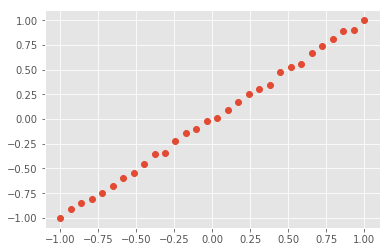

In [3]:
def perturb(x):
    """Randomly perturb the points x while maintaining monotonicity."""
    h = numpy.diff(x) # distance between each successive grid point
    minh = numpy.minimum(h[:-1], h[1:]) # distance to closest of left and right neighbor
    y = x.copy()
    y[1:-1] += minh * (numpy.random.rand(len(minh)) - 0.5)
    return y

y = perturb(x)
pyplot.plot(x, y, 'o');

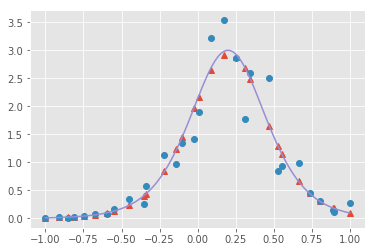

In [4]:
Dy = diffmat(y)
pyplot.plot(y, Dy @ ref.u(y), '^')
pyplot.plot(y, Dx @ ref.u(y), 'o')
pyplot.plot(xx, ref.du(xx));

Note that the uniform derivative operator `Dx` is junk when used for data on an unevenly spaced grid.

The second derivative is defined similarly to `diffmat`.

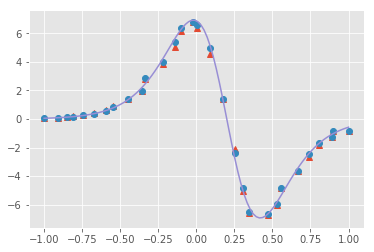

In [5]:
def diff2mat(x):
    m = len(x)
    D2 = numpy.zeros((m, m))
    D2[0,:3] = fdstencil(x[0], x[:3])[2]
    for i in range(1, m-1):
        D2[i, i-1:i+2] = fdstencil(x[i], x[i-1:i+2])[2]
    D2[-1,-3:] = fdstencil(x[-1], x[-3:])[2]
    return D2

D2x = diff2mat(x)
D2y = diff2mat(y)
pyplot.plot(y, D2x @ ref.u(x), '^')
pyplot.plot(y, D2y @ ref.u(y), 'o')
pyplot.plot(xx, ref.ddu(xx));

## Convergence study

We will work in the max ($\infty$) norm.

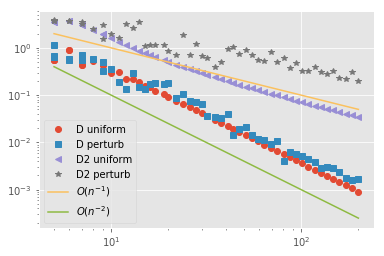

In [6]:
def mms_errors(n):
    x = numpy.linspace(-1, 1, n)
    y = perturb(x)
    Dx = diffmat(x)
    Dy = diffmat(y)
    D2x = diff2mat(x)
    D2y = diff2mat(y)
    return (numpy.linalg.norm(Dx @ ref.u(x) - ref.du(x), numpy.inf),
            numpy.linalg.norm(Dy @ ref.u(y) - ref.du(y), numpy.inf),
            numpy.linalg.norm(D2x @ ref.u(x) - ref.ddu(x), numpy.inf),
            numpy.linalg.norm(D2y @ ref.u(y) - ref.ddu(y), numpy.inf))

ns = numpy.geomspace(5, 200, dtype=int)
errors = numpy.array([mms_errors(n) for n in ns])
pyplot.loglog(ns, errors[:,0], 'o', label='D uniform')
pyplot.loglog(ns, errors[:,1], 's', label='D perturb')
pyplot.loglog(ns, errors[:,2], '<', label='D2 uniform')
pyplot.loglog(ns, errors[:,3], '*', label='D2 perturb')
pyplot.loglog(ns, 10*ns**(-1.), label='$O(n^{-1})$')
pyplot.loglog(ns, 10*ns**(-2.), label='$O(n^{-2})$')
pyplot.legend();

Evidently the first derivative operators are all second order while the second derivatives are first order on uniform grids and noisy (but probably still first order in the limit) on non-uniform grids.